<a href="https://colab.research.google.com/github/671454/9.sept-innlevering/blob/master/LayoutLMv3_kvp10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os              #navigere mapper og filer, hente filbaner
from PIL import Image  #åpne, vise og manipulere bilder
import json            #lese/skrive til JSON-filer


#Installer nødvendige biblioteker
!pip install -q Pillow
!pip install -q transformers datasets torch torchvision

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/train"
print(os.listdir(base_path))

['ocrs', 'gts', 'images', 'items']


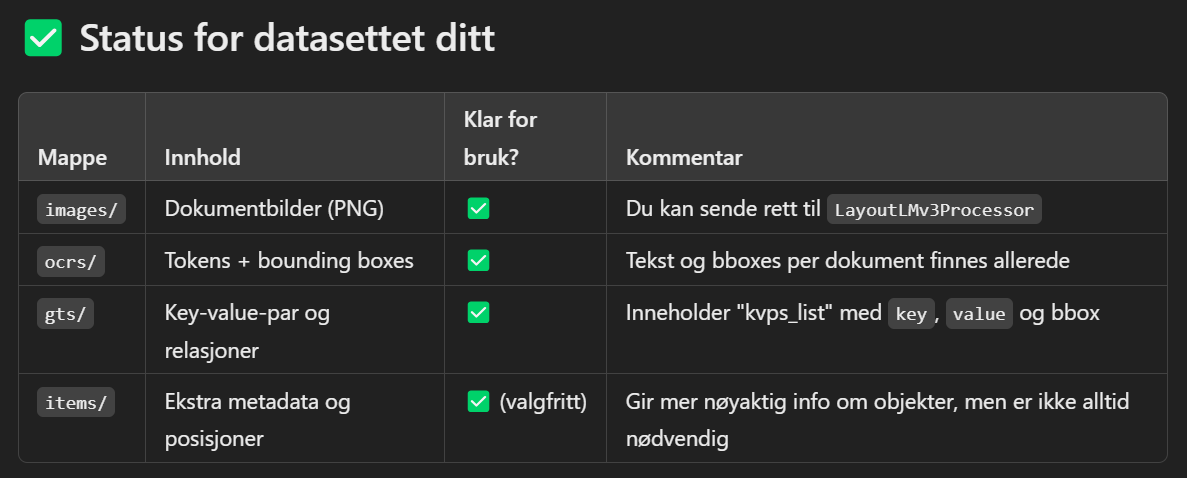

# LayoutLMv3 - Hva skal jeg bruke?

- Steg 1. Må utføre Entity Extraction (EE).

- Steg 2. Utføre Relation Exctraction (RE). Formaliser RE som et matrise-problem, hvor man for alle par av entiteter **predikerer** om en relasjon finnes.
  - Relasjoner kan representeres som en N x N matrise over entitets-paret (i, j).

- Bruk en enkelt treningspipeline.

- Bruke **LayoutLMv3Processor** for å kombinere bilde, tekst, og bboxes, for å lage den input modellen krever.

- Bruke **LayoutLMv3ForTokenClassification** som modell for per-token tagging (EE).
  - Denne brukes for Entity tagging.
  - UTVID MED --> Ekstra kode for "*span grouping*" og "*entity embedding*".

#========================================================================

Steg 1:
  - Tagge tokens med (O, B-KEY, B-VALUE, I-KEY, I-VALUE), og derretter koble KEY --> VALUE.

Label-mappinger:


```
label2id = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}
```



Steg 2:
LayoutLMv3Model er grunnlag for RE.
For å bruke denne modellen som egentlig er PyTorch Native, må vi bruke installere *transformers* og bruke PyTorch-backend.
UTVID med --> Egen relasjonsklassifisering mellom *key* og *value* spans
  - Kobling mellom key og value:
    1. Hente predikerte spanse fra EE
    2. Lage relasjonsprediksjonsmodell RE

*Hentet fra:* https://arxiv.org/html/2404.10848v1


# Oppsummert

- Bruke LayoutLMv3Processor for å kombinere bilde, tokens, og bounding boxes (bboxes).

- Bruke LayoutLMv3ForTokenClassification til å tagge tokens som B-KEY, B-VALYE, O, etc.


1. Må utvide LayoutLMv3Model til å hente embeddings.
2. Implementere RE ved å sammenligne KVPs.
3. Evaluer RE med F1/Precision/Recall per relasjon.

#PyTorch (+ Hugging Face)
LayoutLMv3 er en del av *transformers*-biblioteket til Hugging Face.
Dette betyr at enten så må hele pipelinen utvikles i PyTorch, eller utvikle bare EE i PyTorch og få KEY-VALUE-Spans, så brukes TensorFlow for resten.

- Siden jeg er generelt usikker på begge bibliotekene så får vi se hva som blir valgt etterhvert...


# STEG 1 - Entity Exctraction